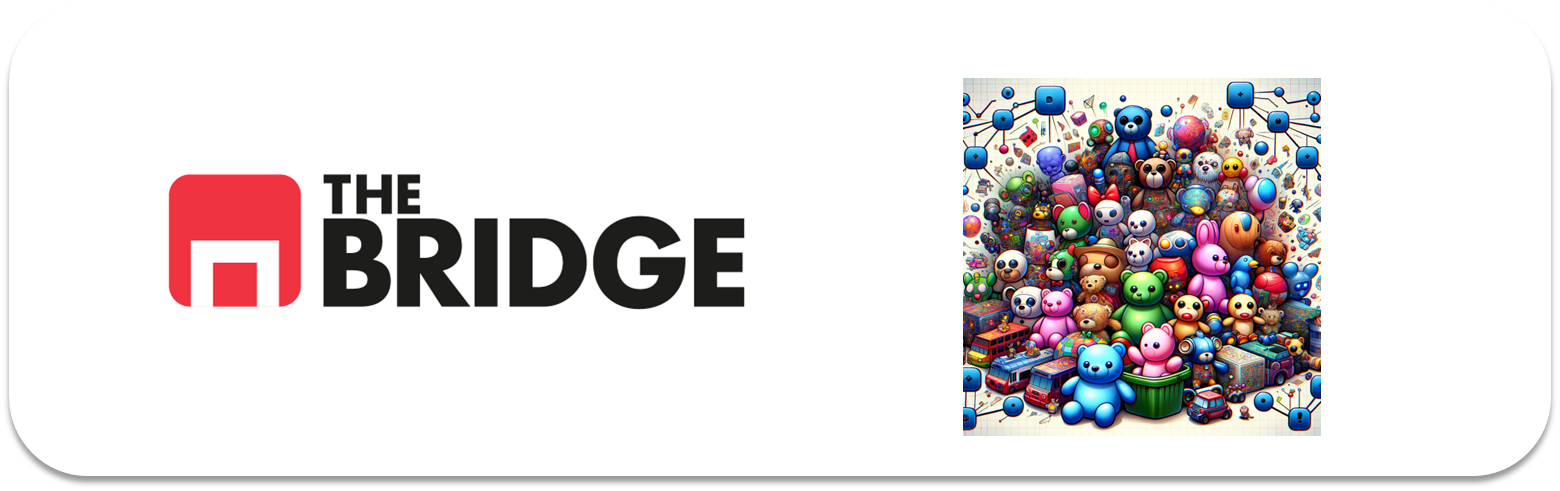

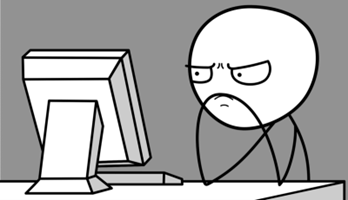

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [83]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


#### Comprobación de datos

In [2]:
df = pd.read_csv("./data/empowering_drinks.csv", sep='|')
df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [3]:
df.info()   # Sin presencia de nulos 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


#### MiniEDA

In [4]:
df.describe().T     # Datos escalados con StandardScaler (media~0 y sd~1)

,count,mean,std,min,25%,50%,75%,max
Azúcares,153.0,0.019231,1.026182,-2.434235,-0.816038,0.061000,0.876275,2.259772
Vitamínas del grupo B,153.0,0.037273,0.995984,-3.679162,-0.499016,-0.023821,0.707247,3.156325
Cafeína,153.0,0.041057,1.040928,-1.695971,-1.043392,0.211566,0.894264,3.062832
Ácido Cítrico,153.0,0.080022,1.009450,-1.493188,-0.738463,-0.165254,0.917474,2.971473
Taurina,153.0,-0.044088,0.934399,-1.634288,-0.799428,-0.154899,0.493956,2.431870


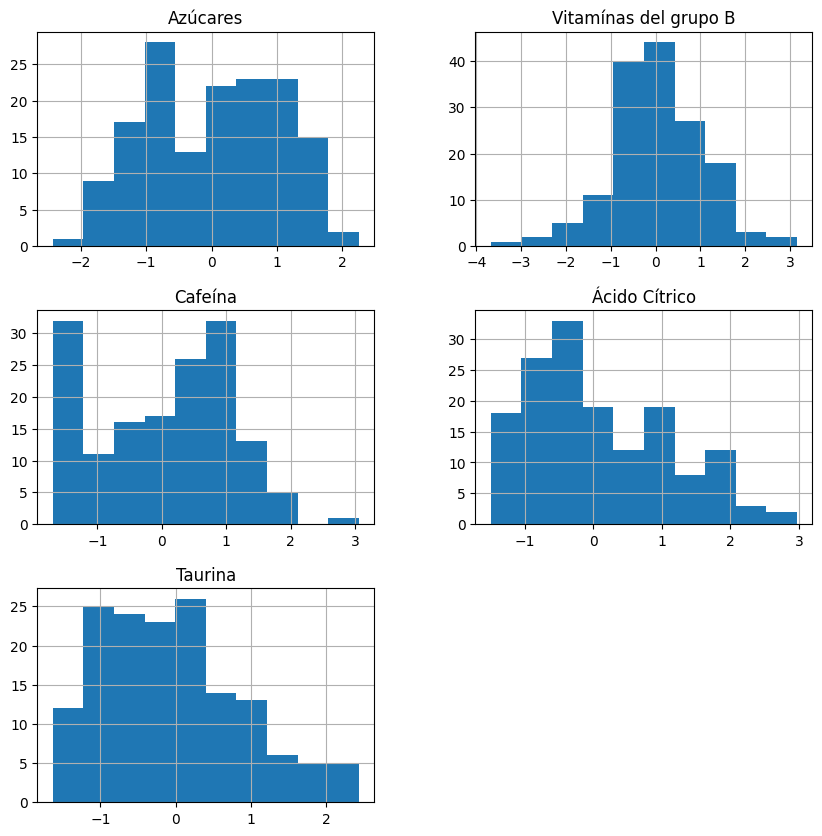

In [5]:
df.hist(figsize=(10,10));

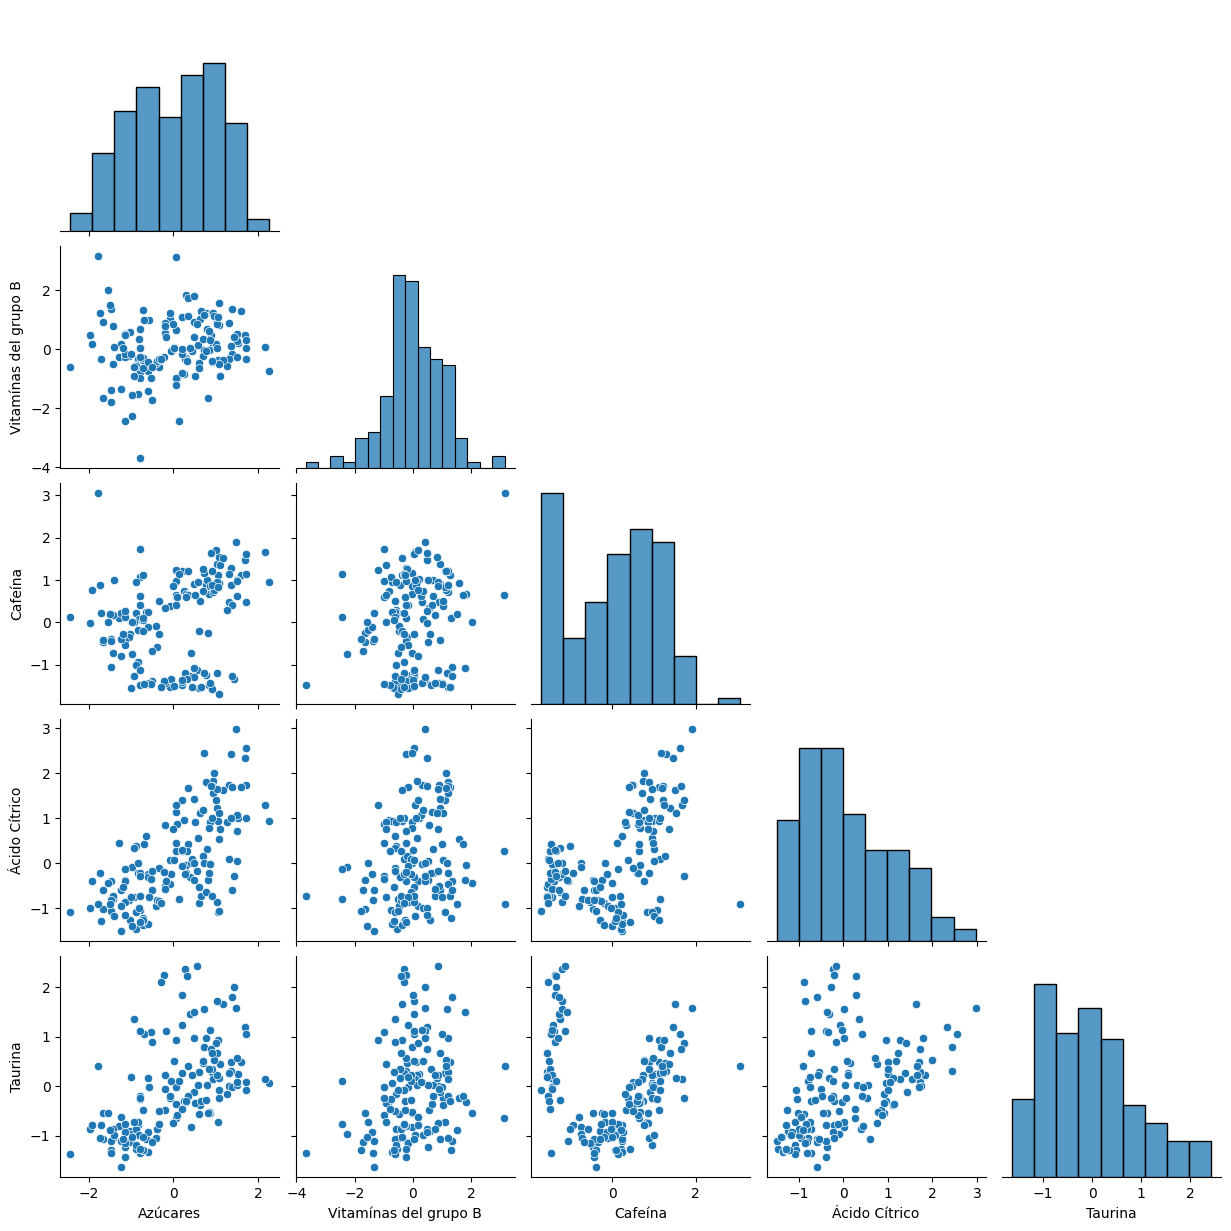

In [6]:
sns.pairplot(df, corner=True);

In [7]:
# Las vitaminas del grupo B parece que no tienen relación con las otras variables
# Vamos a comprobarlo numéricamente

df.corr()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
Azúcares,1.000000,0.174354,0.258166,0.672969,0.553245
Vitamínas del grupo B,0.174354,1.000000,0.155276,0.208444,0.215869
Cafeína,0.258166,0.155276,1.000000,0.497329,-0.124157
Ácido Cítrico,0.672969,0.208444,0.497329,1.000000,0.408325
Taurina,0.553245,0.215869,-0.124157,0.408325,1.000000


In [8]:
# Podríamos descartarla

X = df.drop('Vitamínas del grupo B', axis=1)

#### Modelado

In [9]:
# Para valores de 'vecinos mínimos' (min_smples) pensar en el número de grupos frente a número total de datos 
# Por tanto, si tenemos alrededor de 150 grupos y busco hasta 5 clusters, podríamos probar con min_saamples = [3, 5, 10]
# 
# Para los valores de EPS (distancia máxima entre vecinos) revisaremos el rango de unidades,
# y podemos calcular el módulo de la diagonal para cubrir todo el plano bidimensional
# En este caso, si nos fijamos en la taurina y la cafeína, que parecen generar al menos 3 clusters, la diagonal mide 6 unidades
# Por tanto, podemos probar con un rango de 100 valores entre 0,001 y 6 -> np.linspace(0,01,6,100)

In [13]:
# Vamos a buscar le mejor valor de EPS

anomalias = []
for eps in np.linspace(0.001,3,50):
    cluster = DBSCAN(eps=eps, min_samples=X.shape[1]*2) # Recomendación en workout, pero podemos probar varios valores con un bucle for
    cluster.fit(X)

    perc_anomalias = np.sum(cluster.labels_ == -1) / len(cluster.labels_)*100
    anomalias.append(perc_anomalias)

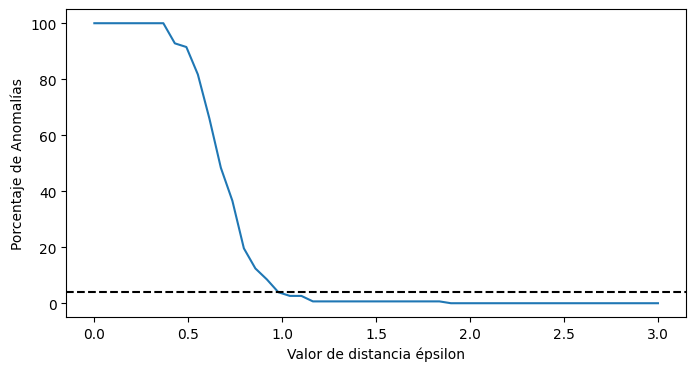

In [15]:
#Vamos a pintar ahora el porcentaje de anomalías vs el valor de eps probado

plt.figure(figsize = (8,4), dpi = 100)
sns.lineplot(x=np.linspace(0.001,3,50),y=anomalias)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de distancia épsilon")
plt.axhline(4, color='k', linestyle='--')
#plt.ylim(0,20)
plt.show()

In [16]:
# Vemos que con EPS = 1 obtenemos un porcentaje de anomalias <5 %

cluster = DBSCAN(eps=1, min_samples=X.shape[1]*2)
cluster.fit(X)

DBSCAN(eps=1, min_samples=8)

#### Resultado

In [36]:
values, counts = np.unique(cluster.labels_, return_counts=True)

print('Clusteres:', max(values)+1)
print(f'Anomalías: {round(counts[0]/len(X)*100, 2)} %')

Clusteres: 2
Anomalías: 3.92 %


In [ ]:
# Muy pocos clusteres, ya que NEGOCIO nos pide un minimo de 3
# Vamos a probar varias combinaciones de min_samples
# Eliminamos una feature porque con 4 no convencía la division

for n in range(1, 10):
    for eps in np.linspace(0.01, 2, 20):
        cluster = DBSCAN(eps=eps, min_samples=n)
        cluster.fit(X[['Cafeína', 'Ácido Cítrico', 'Taurina']])

        values, counts = np.unique(cluster.labels_, return_counts=True)
        num_clusters = max(values)+1
        perc_anomalias = round(counts[0]/len(X)*100, 2)

        if 3 <= num_clusters <= 5 and perc_anomalias <= 10:
            print(f'Nº vecinos: {n} - EPS: {eps}')
            print(f'Clusteres: {num_clusters}')
            print(f'Anomalías: {perc_anomalias} %\n')

Nº vecinos: 2 - EPS: 0.5336842105263158
Clusteres: 4
Anomalías: 3.92 %

Nº vecinos: 2 - EPS: 0.638421052631579
Clusteres: 3
Anomalías: 3.27 %

Nº vecinos: 3 - EPS: 0.5336842105263158
Clusteres: 4
Anomalías: 3.92 %

Nº vecinos: 3 - EPS: 0.638421052631579
Clusteres: 3
Anomalías: 3.27 %

Nº vecinos: 4 - EPS: 0.5336842105263158
Clusteres: 4
Anomalías: 5.23 %

Nº vecinos: 4 - EPS: 0.638421052631579
Clusteres: 3
Anomalías: 3.27 %

Nº vecinos: 5 - EPS: 0.5336842105263158
Clusteres: 3
Anomalías: 9.8 %



#### Comprobación

In [76]:
# Tenemos EPS ganador y varios vecinos mínimos que parecen arrojar el mismo resultado

cluster = DBSCAN(eps=0.64, min_samples=2)
cluster.fit(X[['Cafeína', 'Ácido Cítrico', 'Taurina']])

values, counts = np.unique(cluster.labels_, return_counts=True)
num_clusters = max(values)+1
perc_anomalias = round(counts[0]/len(X)*100, 2)

print(f'Clusteres: {num_clusters}')
print(f'Anomalías: {perc_anomalias} %\n')

Clusteres: 3
Anomalías: 2.61 %



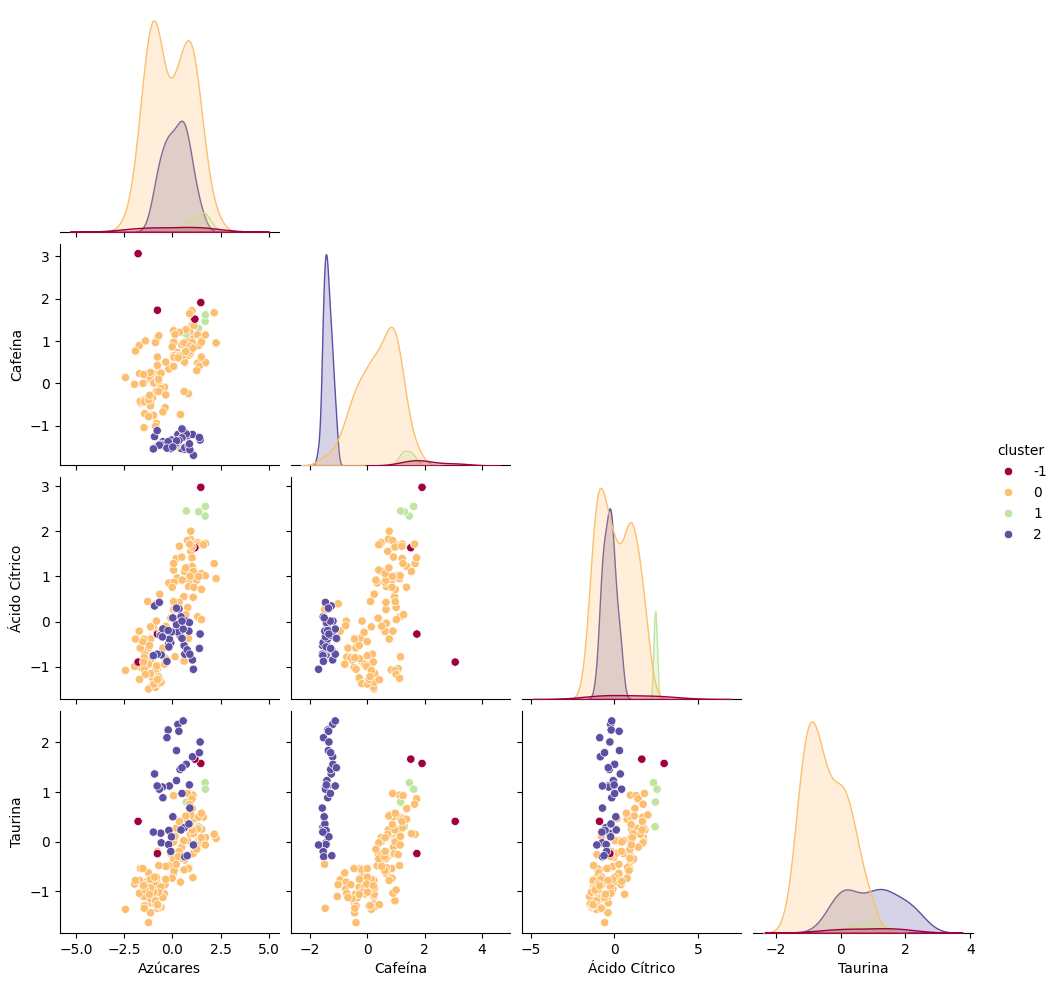

In [77]:
test = X.copy()
test['cluster'] = cluster.labels_
sns.pairplot(test, hue='cluster', corner=True, palette='Spectral');

In [ ]:
# Este modelo arroja dos clusteres principales más otro con un toque fuerte de 'acido cítrico' 

#### Diagrama jerárquico

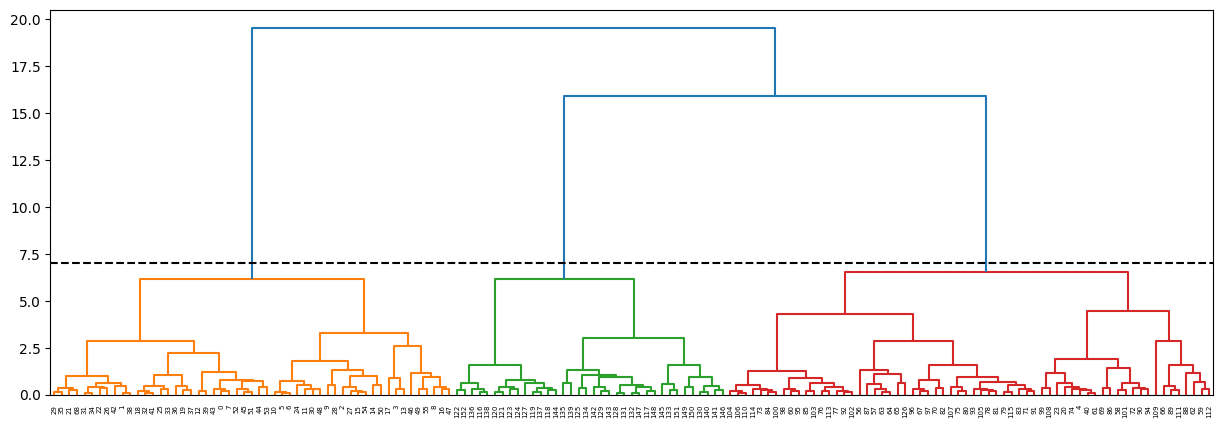

In [85]:
link_method = linkage(X[['Cafeína', 'Ácido Cítrico', 'Taurina']], method='ward')
plt.figure(figsize=(15,5))
dend = dendrogram(link_method)
plt.axhline(7, linestyle='--', color='k');

In [95]:
clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(X[['Cafeína', 'Ácido Cítrico', 'Taurina']])
test = X.copy()
test['cluster'] = clustering_model.labels_

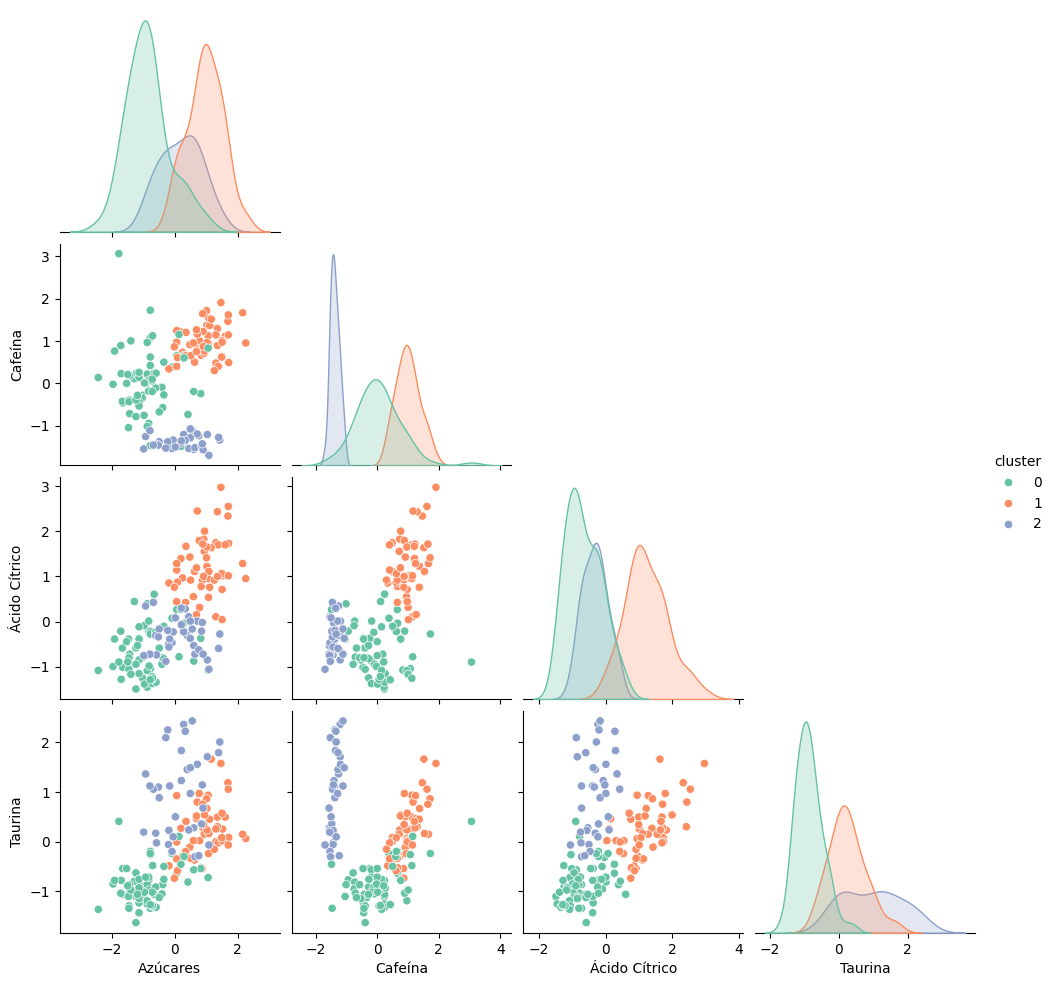

In [97]:
sns.pairplot(test, hue='cluster', corner=True, palette='Set2');

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.